In [10]:
import os
import numpy as np
import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="1"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


import cv2
from functools import partial
import math
from tqdm import tqdm
import time as time

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure 
from torchmetrics.functional import peak_signal_noise_ratio 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.io as sio
from astropy.io import fits

import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg



True
1
0
NVIDIA A100-PCIE-40GB


First, we need to define some heuristics for the solver, these include:

      - tol: convergence criteria for the iterations
      - iter: maximum number of iterations
      - update_iter: iterations between logging iteration diagnostics
      - record_iters: whether to record the full diagnostic information



In [11]:
options = {"tol": 1e-5, "iter": 5000, "update_iter": 4999, "record_iters": False}


In [12]:
img_name = 'M31'

# Load img
img_path = '/disk/xray0/tl3/repos/large-scale-UQ/data/imgs/{:s}.fits'.format(img_name)
img_data = fits.open(img_path, memmap=False)

# Loading the image and cast it to float
img = np.copy(img_data[0].data)[0,:,:].astype(np.float64)
# Flipping data
img = np.flipud(img)

# Aliases
x = img
ground_truth = img

INSTRUME                                                                         [astropy.io.fits.card]


In [13]:
# Load op from X Cai
op_mask = sio.loadmat('/disk/xray0/tl3/repos/large-scale-UQ/data/operators_masks/fourier_mask.mat')['Ma']

# Matlab's reshape works with 'F'-like ordering
mat_mask = np.reshape(np.sum(op_mask, axis=0), (256,256), order='F').astype(bool)

In [14]:

torch_img = torch.tensor(np.copy(img), dtype=torch.float32, device=device).reshape((1,1) + img.shape)


In [15]:
dim = 256
phi = luq.operators.MaskedFourier_torch(
    dim=dim, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)



In [16]:
# Define X Cai noise level
sigma = 0.0024

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Generate noise
rng = np.random.default_rng(seed=0)
n = rng.normal(0, sigma, y[y!=0].shape)
# Add noise
y[y!=0] += n

# Observation
torch_y = torch.tensor(np.copy(y), device=device).reshape((1,1) + img.shape)
x_init = torch.abs(phi.adj_op(torch_y))


In [23]:

g = luq.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# g.beta = 1.0 / sigma ** 2


In [24]:

device = 'cuda:0'
torch.set_grad_enabled(False)
torch.set_num_threads(4)

sigma_training = 5
t_model = 5
dir_name = '/disk/xray0/tl3/repos/convex_ridge_regularizers/trained_models/'
exp_name = f'Sigma_{sigma_training}_t_{t_model}/'
model = utils_cvx_reg.load_model(dir_name+exp_name, device, device_type='gpu')

print(f'Numbers of parameters before prunning: {model.num_params}')
model.prune()
print(f'Numbers of parameters after prunning: {model.num_params}')

L = model.L.detach().cpu().squeeze().numpy()
print(f"Lipschitz bound {L:.3f}")


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183
Lipschitz bound 0.770


In [25]:
# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
L = model.L.data.item()
print(f"Lipschitz bound {L:.3f}")


Lipschitz bound 0.770


In [26]:
# to_tensor = lambda _z : torch.tensor(
#     _z, device=device, dtype=torch.float, requires_grad=False
# ).reshape((1,1) + _z.shape)
# to_numpy = lambda _z : _z.detach().cpu().squeeze().numpy()

In [32]:
lmbd = 5e3
mu = 20

# Compute stepsize
alpha = 1. / ( 1. + g.beta + mu * lmbd * L)

# initialization
x_hat = torch.clone(x_init)
z = torch.clone(x_init)
t = 1


In [33]:
for it in range(options['iter']):
    x_hat_old = torch.clone(x_hat)
    # grad = g.grad(z.squeeze()) +  lmbd * model(mu * z)
    x_hat = z - alpha *(
        g.grad(z) + lmbd * model(mu * z)
    )
    # Positivity constraint
    x_hat =  torch.real(x_hat)
    # possible constraint, AGD becomes FISTA
    # e.g. if positivity
    # x = torch.clamp(x, 0, None)
    
    t_old = t 
    t = 0.5 * (1 + math.sqrt(1 + 4*t**2))
    z = x_hat + (t_old - 1)/t * (x_hat - x_hat_old)

    # relative change of norm for terminating
    res = (torch.norm(x_hat_old - x_hat)/torch.norm(x_hat_old)).item()

    if res < options['tol']:
        print("[GD] converged in %d iterations"%(it))
        break

    if it % options['update_iter'] == 0:
        print(
            "[GD] %d out of %d iterations, tol = %f" %(            
                it,
                options['iter'],
                res,
            )
        )


[GD] 0 out of 5000 iterations, tol = 0.284909
[GD] converged in 2250 iterations


In [34]:
np_x_init = to_numpy(x_init)
np_x = np.copy(x)
np_x_hat = to_numpy(x_hat)

images = [np_x, np_x_init, np_x_hat, np_x - np.abs(np_x_hat)]


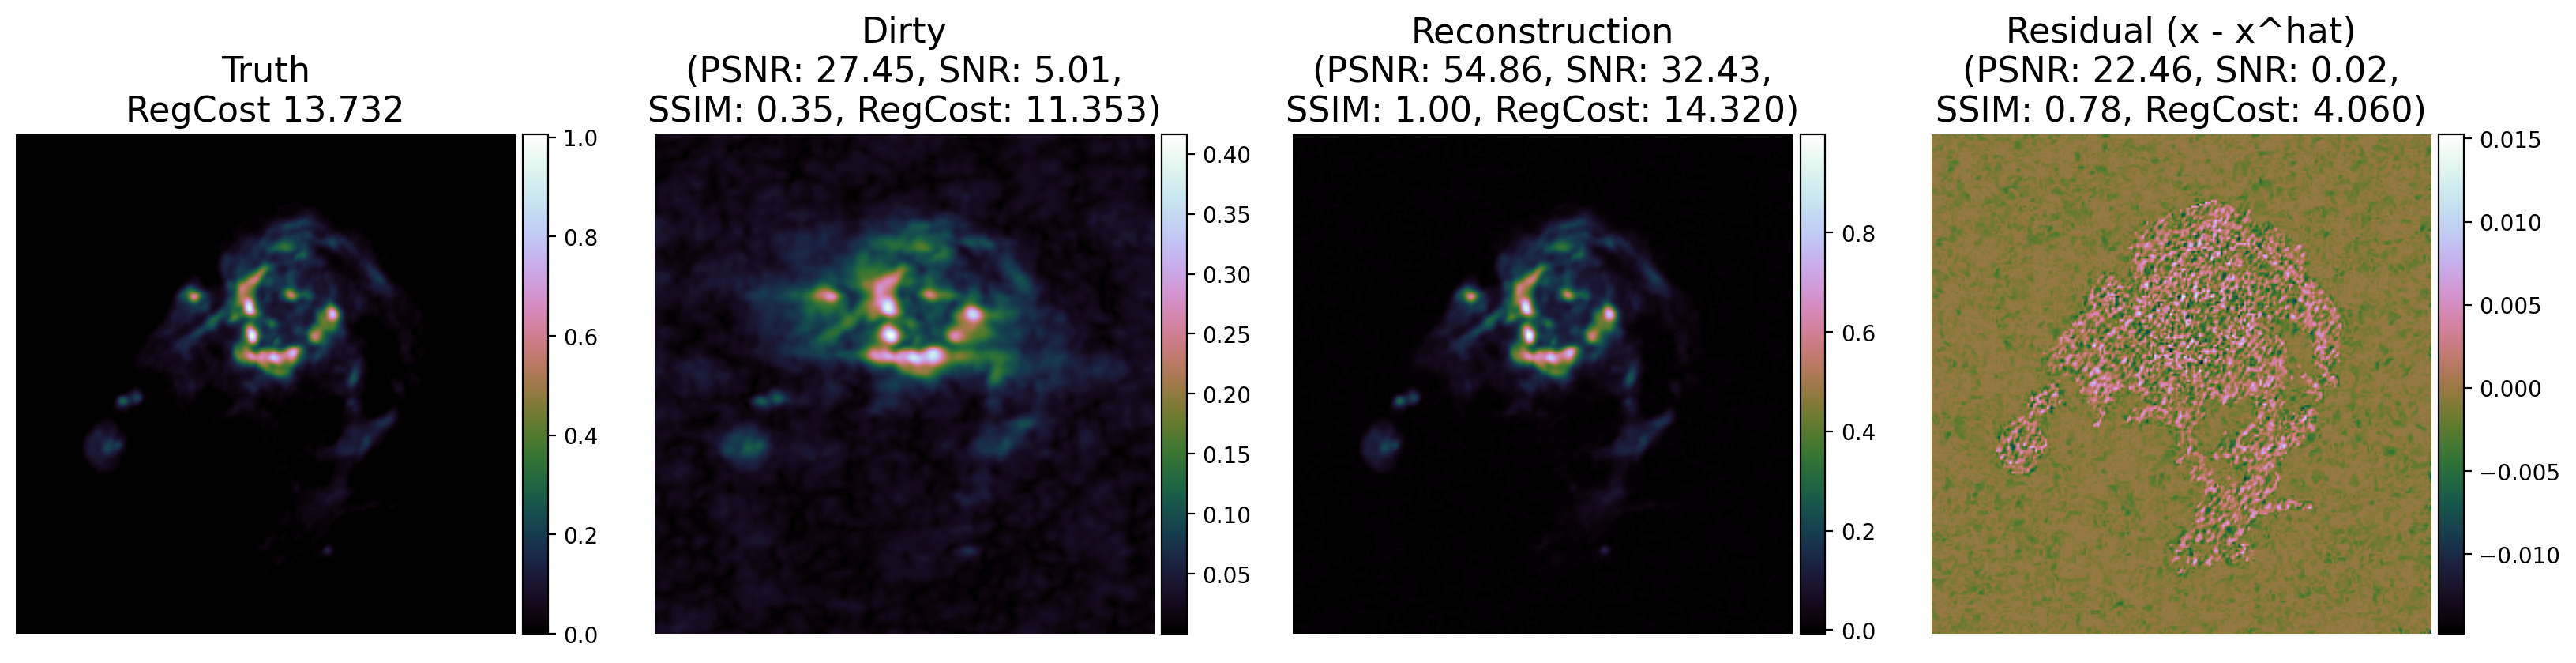

In [35]:
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]
fig, axs = plt.subplots(1,4, figsize=(20,8), dpi=200)
for i in range(4):
    im = axs[i].imshow(images[i], cmap='cubehelix', vmax=np.nanmax(images[i]), vmin=np.nanmin(images[i]))
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i == 0:
        stats_str = '\nRegCost {:.3f}'.format(model.cost(to_tensor(mu * images[i], device=device))[0].item())
    if i > 0:   
        stats_str = '\n(PSNR: {:.2f}, SNR: {:.2f},\nSSIM: {:.2f}, RegCost: {:.3f})'.format(
            psnr(np_x, images[i], data_range=np_x.max()-np_x.min()),
            luq.utils.eval_snr(x, images[i]),
            ssim(np_x, images[i], data_range=np_x.max()-np_x.min()),
            model.cost(to_tensor(mu * images[i], device=device))[0].item(),
            )
    labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')
# plt.savefig('{:s}{:s}_MAP.pdf'.format(savefig_dir, save_name))
# plt.close()
plt.show()

## Now sampling

In [31]:

# A = lambda _x : phi.dir_op(_x)
# At = lambda _x : phi.adj_op(_x)

# max_val = luq.utils.max_eigenval(
#     A=A,
#     At=At,
#     im_size=dim,
#     tol=1e-4,
#     max_iter=int(1e4),
#     verbose=0,
#     device=device
# )

In [36]:
# mu = 20
# lmbd = 100

# lmbd = 2.5e3
# mu = 20

#function handles to used for ULA
# def _fun(_x, model, mu, lmbd):
#     return (lmbd / mu) * model.cost(mu * _x) + g.fun(_x)

# def _grad_fun(_x, g, model, mu, lmbd):
#     return  torch.real(g.grad(_x) + lmbd * model(mu * _x))

# def _grad_fun_v2(_x, g, model, mu, lmbd):
#     return  g.grad(_x) + lmbd * model(mu * torch.real(_x))

# fun = partial(_fun, model=model, mu=mu, lmbd=lmbd)
# grad_f = partial(_grad_fun, g=g, model=model, mu=mu, lmbd=lmbd)

# grad_f_v2 = partial(_grad_fun_v2, g=g, model=model, mu=mu, lmbd=lmbd)

# fun = lambda _x: lmbd/mu * model.cost(mu * _x) + g.fun(_x)
# grad_f = lambda _x: g.grad(_x) + lmbd * model(mu * _x)



#function handles to used for ULA
def _fun(_x, model, mu, lmbd):
    return (lmbd / mu) * model.cost(mu * _x) + g.fun(_x)

def _grad_fun(_x, g, model, mu, lmbd):
    return  torch.real(g.grad(_x) + lmbd * model(mu * _x))

fun = partial(_fun, model=model, mu=mu, lmbd=lmbd)
grad_f = partial(_grad_fun, g=g, model=model, mu=mu, lmbd=lmbd)


#ULA kernel
def ULA_kernel(_x, delta):
    return _x - delta * grad_f(_x) + math.sqrt(2 * delta) * torch.randn_like(_x)



In [20]:
# aa = grad_f_v2(X)
# bb = g.grad(X)
# cc = model(X)

# print(aa.dtype)
# print(bb.dtype)
# print(cc.dtype)
# print(g.data.dtype)


In [37]:
# Set up sampler
Lip_total = mu * lmbd * L + g.beta 

#step size for ULA
frac_delta = 0.9
gamma = frac_delta / Lip_total

print('gamma: ', gamma)

gamma:  3.591787707801131e-06


In [39]:
# Sampling alg params
frac_burnin = 0.2
n_samples = np.int64(1e2)
thinning = np.int64(1e2)
maxit = np.int64(n_samples * thinning * (1. + frac_burnin))

# Sampling alg params
burnin = np.int64(n_samples * thinning * frac_burnin)
X = x_init.clone()
MC_X = np.zeros((n_samples, X.shape[2], X.shape[3]))
logpi_thinning_trace = np.zeros((n_samples, 1))
thinned_trace_counter = 0
# thinning_step = np.int64(maxit/n_samples)

nrmse_values = []
psnr_values = []
ssim_values = []
logpi_eval = []

In [40]:
start_time = time.time()
for i_x in tqdm(range(maxit)):

    # Update X
    X = ULA_kernel(X, gamma)
    # X = MYULA_kernel(X, gamma)

    if i_x == burnin:
        # Initialise recording of sample summary statistics after burnin period
        post_meanvar = luq.utils.welford(X)
        absfouriercoeff = luq.utils.welford(torch.fft.fft2(X).abs())
    elif i_x > burnin:
        # update the sample summary statistics
        post_meanvar.update(X)
        absfouriercoeff.update(torch.fft.fft2(X).abs())

        # collect quality measurements
        current_mean = post_meanvar.get_mean()
        psnr_values.append(peak_signal_noise_ratio(current_mean, torch_img).item())
        ssim_values.append(structural_similarity_index_measure(current_mean, torch_img).item())
        logpi_eval.append(fun(X).item())

        # collect thinned trace
        if np.mod(i_x- burnin, thinning) == 0:
            MC_X[thinned_trace_counter] = X.detach().cpu().numpy()
            thinned_trace_counter += 1

end_time = time.time()
elapsed = end_time - start_time    

current_mean = post_meanvar.get_mean()
current_var = post_meanvar.get_var().detach().cpu().squeeze()


100%|██████████| 12000/12000 [00:32<00:00, 370.03it/s]


In [42]:

save_dir = '/disk/xray0/tl3/repos/large-scale-UQ/notebooks/figs_sampling/'

params = {
    'maxit': maxit,
    'n_samples': n_samples,
    'gamma': gamma,
    'frac_delta': frac_delta,
    'mu': mu,
    'lmbd': lmbd,
}
save_vars = {
    'post_meanvar': post_meanvar,
    'MC_X': MC_X,
    'X': to_numpy(X),
    'params': params,
}

save_prefix = 'frac_delta_{:.1e}_lmbd_{:.1e}_maxit_{:.1e}_frac_burnin_{:.1e}'.format(
    frac_delta, lmbd, maxit, frac_burnin
)
save_path = '{:s}{:s}{:s}'.format(save_dir, save_prefix, '_vars.npy')
# np.save(save_path, save_vars, allow_pickle=True)


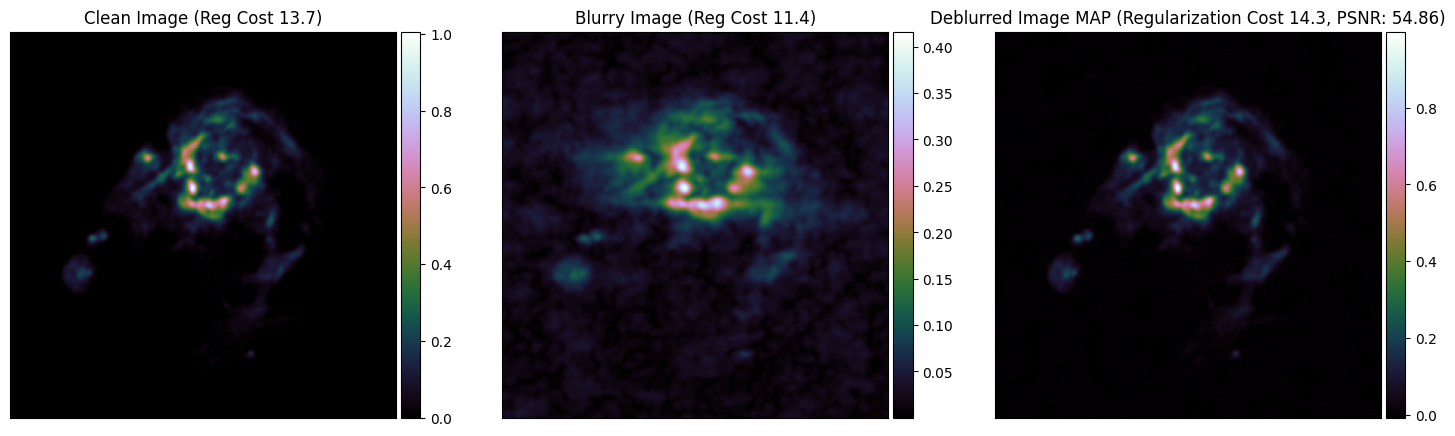

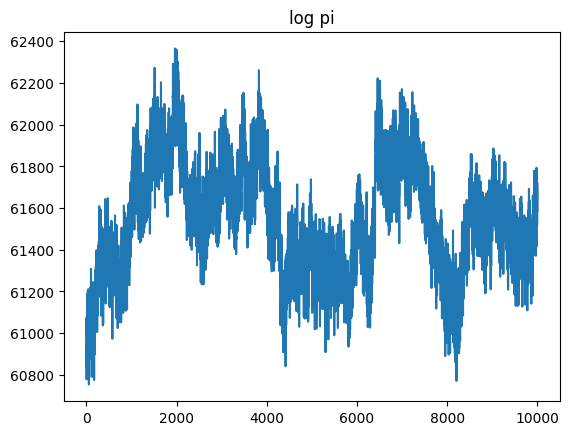

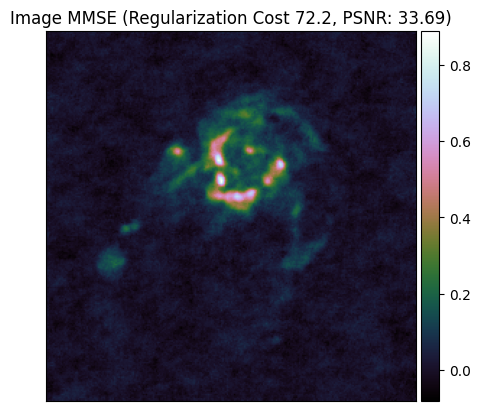

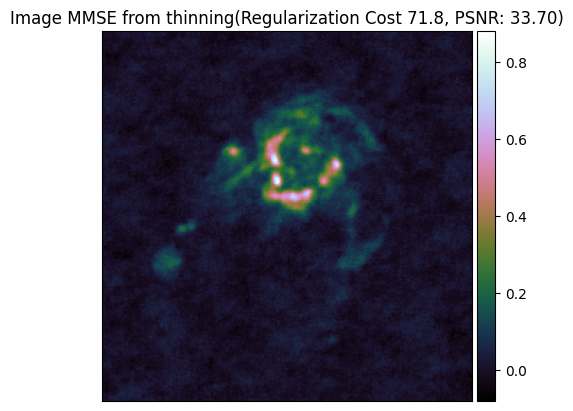

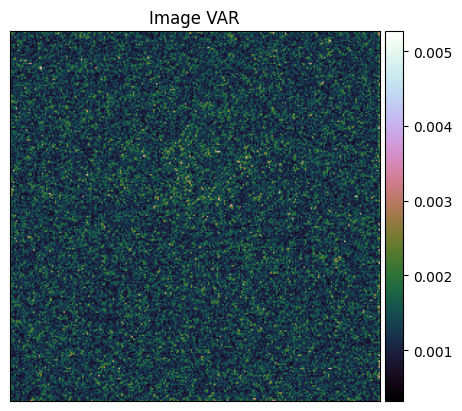

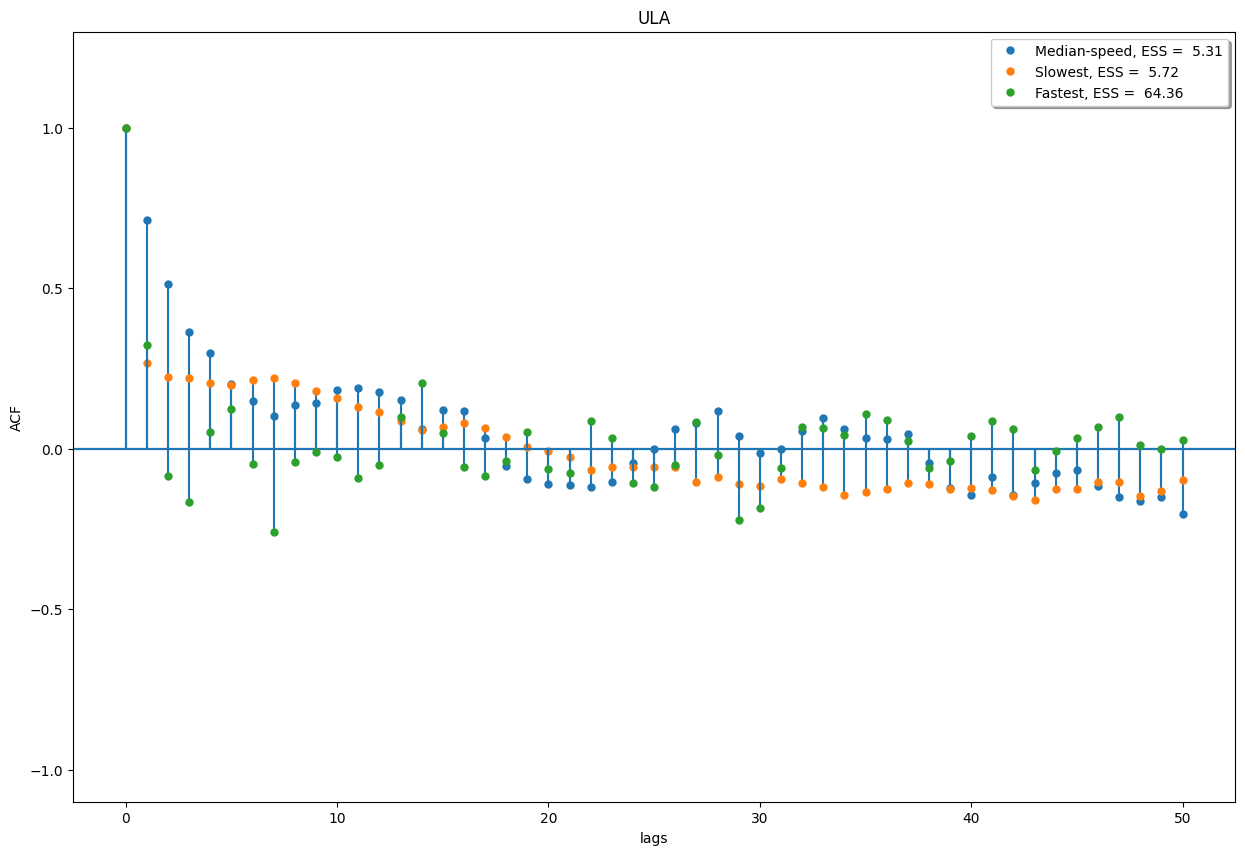

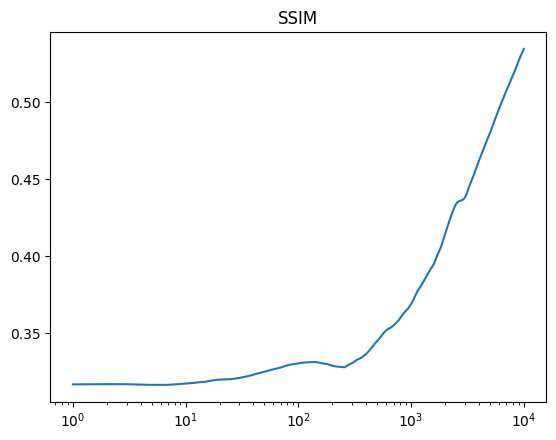

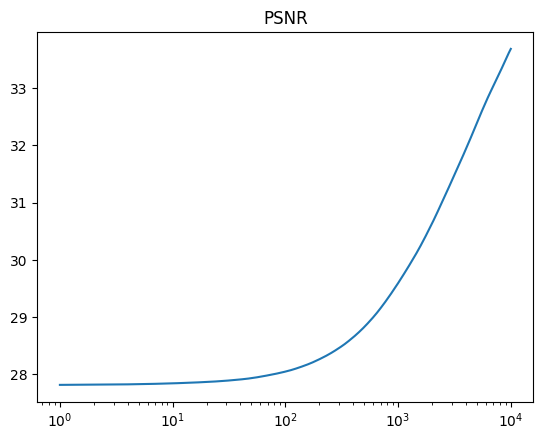

In [43]:
cmap='cubehelix'

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
ax[0].set_title(f"Clean Image (Reg Cost {model.cost(mu*torch_img)[0].item():.1f})")
im = ax[0].imshow(torch_img.detach().cpu().squeeze(), cmap=cmap)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[0].set_yticks([]);ax[0].set_xticks([])

ax[1].set_title(f"Blurry Image (Reg Cost {model.cost(mu*x_init)[0].item():.1f})")
im = ax[1].imshow(x_init.detach().cpu().squeeze(), cmap=cmap)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[1].set_yticks([]);ax[1].set_xticks([])

ax[2].set_title(f"Deblurred Image MAP (Regularization Cost {model.cost(mu*x_hat)[0].item():.1f}, PSNR: {peak_signal_noise_ratio(x_hat, torch_img).item():.2f})")
im = ax[2].imshow(x_hat.detach().cpu().squeeze(), cmap=cmap)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[2].set_yticks([]);ax[2].set_xticks([])
# plt.savefig(save_dir+save_prefix+'_MAP_optim.pdf')
plt.show()


fig, ax = plt.subplots()
ax.set_title("log pi")
ax.plot(np.arange(1,len(logpi_eval)+1), logpi_eval)
# plt.savefig(save_dir+save_prefix+'_log_pi_sampling.pdf')
plt.show()

fig, ax = plt.subplots()
ax.set_title(f"Image MMSE (Regularization Cost {model.cost(mu*current_mean)[0].item():.1f}, PSNR: {peak_signal_noise_ratio(current_mean, torch_img).item():.2f})")
im = ax.imshow(current_mean.detach().cpu().squeeze(), cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([]);ax.set_xticks([])
# plt.savefig(save_dir+save_prefix+'_MMSE_sampling.pdf')
plt.show()


MC_X_mean = np.mean(MC_X, axis=0)

fig, ax = plt.subplots()
ax.set_title(f"Image MMSE from thinning(Regularization Cost {model.cost(mu*to_tensor(MC_X_mean, device=device))[0].item():.1f}, PSNR: {peak_signal_noise_ratio(to_tensor(MC_X_mean, device=device), torch_img).item():.2f})")
im = ax.imshow(MC_X_mean, cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([])
ax.set_xticks([])
# plt.savefig(save_dir+save_prefix+'_MMSE_thinning_sampling.pdf')
plt.show()

fig, ax = plt.subplots()
ax.set_title(f"Image VAR")
im = ax.imshow(current_var, cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([]);ax.set_xticks([])
# plt.savefig(save_dir+save_prefix+'_variance_sampling.pdf')
plt.show()

luq.utils.autocor_plots(
    MC_X,
    current_var,
    "ULA",
    nLags=50,
    save_path=save_dir+save_prefix+'_autocorr_plot.pdf'
)

fig, ax = plt.subplots()
ax.set_title("SSIM")
ax.semilogx(np.arange(1,len(ssim_values)+1), ssim_values)
# plt.savefig(save_dir+save_prefix+'_SSIM_evolution.pdf')
plt.show()

fig, ax = plt.subplots()
ax.set_title("PSNR")
ax.semilogx(np.arange(1,len(psnr_values)+1), psnr_values)
# plt.savefig(save_dir+save_prefix+'_PSNR_evolution.pdf')
plt.show()



In [67]:
def to_tensor(z, device='cuda', dtype=torch.float):
    return torch.tensor(
        z, device=device, dtype=dtype, requires_grad=False
    ).reshape((1,1) + z.shape)